# Designing our SegNet

This notebook firstly constructs a SegNet based of the tutorial found here: https://www.tensorflow.org/tutorials/images/segmentation

From here we hyperparameter tune the network and benchmark several different network architectures (see Implementation for the results)

The final model is trained on the different datasets. The models are outputted as weights files.


In [89]:
#Load libraries and ensure are using a GPU for training
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 67015159727459260
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6590298194
locality {
  bus_id: 1
  links {
  }
}
incarnation: 385106029071412533
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [90]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from IPython.display import clear_output
import matplotlib.pyplot as plt


In [91]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [92]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\Bhavin\Anaconda3\envs\venv\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [115]:
session.close()

## TF Record Loader
We store the datasets as tensorflow records. These records are loaded into tensors for training.

In [93]:
#Decode the TFRecord data
def parser(record):
    keys_to_features = {
        "image_raw": tf.io.FixedLenFeature([], tf.string),
        "segmentation_mask": tf.io.FixedLenFeature([], tf.string)
    }
    parsed = tf.io.parse_single_example(record, keys_to_features)
    
    image = tf.io.decode_raw(parsed["image_raw"], tf.uint8)
    segmask = tf.io.decode_raw(parsed["segmentation_mask"], tf.uint8)
    return {'image': image,'segmentation_mask':segmask}

In [94]:
# Normalize image and mask before training on it
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask  = tf.cast(input_mask, tf.float32) / 255.0
    return input_image, input_mask

In [95]:
@tf.function
#Load tfRecord training data
def load_image_train(datapoint,size=128):
    input_image = tf.reshape(datapoint['image'],(size,size,3))
    input_mask = tf.reshape(datapoint['segmentation_mask'], (size, size,3))
    #slice the mask
    input_mask = tf.slice(input_mask,[0,0,0],[size,size,1])    
    #Data augmentation
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [96]:
#Load tfRecord testing data
def load_image_test(datapoint,size=128):
    input_image = tf.reshape(datapoint['image'],(int(size),int(size),3))
    input_mask = tf.reshape(datapoint['segmentation_mask'], (size, size,3))
    input_mask = tf.slice(input_mask,[0,0,0],[size,size,1])  
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [97]:
#Training Constant Parameters
TRAIN_LENGTH = 5000
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
print(STEPS_PER_EPOCH)

78


In [98]:
#Loads a TfRecord dataset train and test split
#Shuffles the data and prepares it for batch training 
def generate_dataset(train_filename,test_filename,size):
    #Load and parse the data into the correct format with augmentations.
    #Load training data
    raw_train = tf.data.TFRecordDataset(train_filename)
    #Decode training 
    train = raw_train.map(parser, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(lambda x: load_image_train(x, size))

    #Prepare test data
    raw_test = tf.data.TFRecordDataset(test_filename)
    test = raw_test.map(parser, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(lambda x: load_image_test(x, size))
    
    #Shuffle and batch the datasets
    train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    test_dataset = test.batch(BATCH_SIZE)
    
    return train_dataset,test_dataset,train,test

train_dataset,test_dataset,train,test = generate_dataset('G:/tensorflow_data_set/tensorflow_records/train.tfrecords','G:/tensorflow_data_set/tensorflow_records/test.tfrecords',128)

In [99]:
# View images from the data set
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [100]:
from PIL import Image
print(train.take(2))

<TakeDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>


(128, 128, 3)
(128, 128, 1)


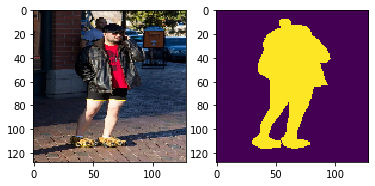

(128, 128, 3)
(128, 128, 1)


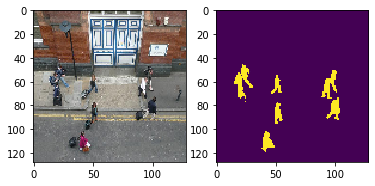

In [101]:
#Extract a sample image to display per epoch
for image, mask in train.take(2):
    sample_image, sample_mask = image, mask
    print(sample_image.shape)
    print(sample_mask.shape)
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image[:,:,:])
    plt.subplot(1, 2, 2)
    plt.imshow(sample_mask[:,:,0])
    plt.show()
    

        

## PFCN dataset
The PFCN dataset was initially a npy file. For training we need to convert this into a TfRecord for training.

### Creating the tf record

(18698, 128, 128, 1)


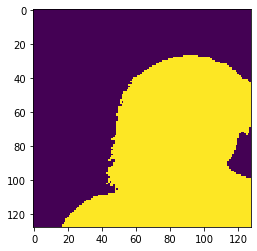

(18698, 128, 128, 3)


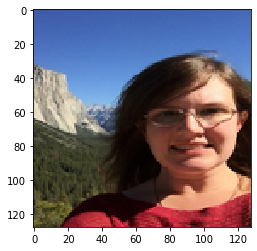

In [14]:
import numpy as np

#Show sample image
train_filename = 'G:/tensorflow_data_set/portadatset/data'
training_masks = np.load(train_filename+'/msk_uint8.npy')
print(training_masks.shape)
plt.imshow(training_masks[0,:,:,0])
plt.show()


training_images = np.load(train_filename+'/img_uint8.npy')
print(training_images.shape)
plt.imshow(training_images[0,:,:,:])
plt.show()

In [15]:
#Decode functions
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [16]:
def load_image(img):
    # read an image and resize to (128,128)
    # cv2 load images as BGR, convert it to RGB
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)
    return img

def load_mask(mask):
    # read an image and resize to (128,128)
    # cv2 load images as BGR, convert it to RGB
    #binarize the mask
    mask_bin = mask
    mask_bin = cv2.resize(mask_bin, (128, 128), interpolation=cv2.INTER_NEAREST)

    return mask_bin    

In [17]:
#We load the images and convert them into a tensorflow TFRecord file. 
import sys
import cv2
def createDataRecord(out_filename,training_masks,training_images):
    #open the TFRecords file
    writer = tf.io.TFRecordWriter(out_filename)
    
    for i in range(0,training_masks.shape[0]):
        #Print progress 
        if not i%250:
            print('Train data: {}/{}'.format(i,training_masks.shape[0]))
            sys.stdout.flush()
    
        #load a image
        img = load_image(training_images[i])
        
        #Load the mask
        mask =  load_mask(training_masks[i])
        
        if img is None:
            continue
        #0 is not person, 1 is person

        #create a feature
        feature = {
            'image_raw': _bytes_feature(img.tostring()),
            'segmentation_mask': _bytes_feature(mask.tostring())
        }
        
        #create example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        
        #serialize to string and write to file
        writer.write(example.SerializeToString())
    writer.close()
    sys.stdout.flush()        

In [18]:
dl_directory = 'G:/tensorflow_data_set'

createDataRecord(dl_directory+'/tensorflow_records/persons_train.tfrecords',training_masks,training_images)

Train data: 0/18698
Train data: 250/18698
Train data: 500/18698
Train data: 750/18698
Train data: 1000/18698
Train data: 1250/18698
Train data: 1500/18698
Train data: 1750/18698
Train data: 2000/18698
Train data: 2250/18698
Train data: 2500/18698
Train data: 2750/18698
Train data: 3000/18698
Train data: 3250/18698
Train data: 3500/18698
Train data: 3750/18698
Train data: 4000/18698
Train data: 4250/18698
Train data: 4500/18698
Train data: 4750/18698
Train data: 5000/18698
Train data: 5250/18698
Train data: 5500/18698
Train data: 5750/18698
Train data: 6000/18698
Train data: 6250/18698
Train data: 6500/18698
Train data: 6750/18698
Train data: 7000/18698
Train data: 7250/18698
Train data: 7500/18698
Train data: 7750/18698
Train data: 8000/18698
Train data: 8250/18698
Train data: 8500/18698
Train data: 8750/18698
Train data: 9000/18698
Train data: 9250/18698
Train data: 9500/18698
Train data: 9750/18698
Train data: 10000/18698
Train data: 10250/18698
Train data: 10500/18698
Train data: 10

(3740, 128, 128, 1)


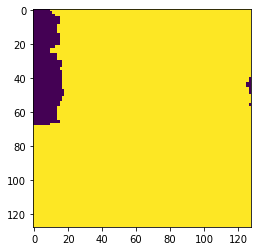

(3740, 128, 128, 3)


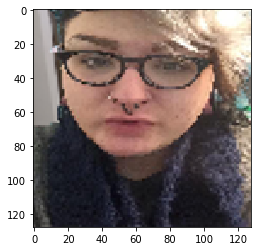

In [19]:
## Do the same for  PFCN test
import numpy as np

persons_filename = 'G:/tensorflow_data_set/portadatset/data'
testing_masks = np.load(persons_filename+'/test_ytrain.npy')
print(testing_masks.shape)
plt.imshow(testing_masks[0,:,:,0])
plt.show()


testing_images = np.load(persons_filename+'/test_xtrain.npy')
print(testing_images.shape)
plt.imshow(testing_images[0,:,:,:])
plt.show()

In [20]:

createDataRecord(dl_directory+'/tensorflow_records/persons_test.tfrecords',testing_masks,testing_images)

Train data: 0/3740
Train data: 250/3740
Train data: 500/3740
Train data: 750/3740
Train data: 1000/3740
Train data: 1250/3740
Train data: 1500/3740
Train data: 1750/3740
Train data: 2000/3740
Train data: 2250/3740
Train data: 2500/3740
Train data: 2750/3740
Train data: 3000/3740
Train data: 3250/3740
Train data: 3500/3740


## PFCN Record loader
Similar process to COCO loader

In [31]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.reshape(datapoint['image'],(128,128,3))
    input_mask = tf.reshape(datapoint['segmentation_mask'], (128, 128,1))

    print(input_mask.shape)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)


    
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.reshape(datapoint['image'],(128,128,3))
    input_mask = tf.reshape(datapoint['segmentation_mask'], (128, 128,1))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [32]:
#Load and parse the data into the correct format with augmentations.
train_filename  = 'G:/tensorflow_data_set/tensorflow_records/persons_train.tfrecords'

raw_train = tf.data.TFRecordDataset(train_filename)
train = raw_train.map(parser, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(load_image_train)

test_filename  = 'G:/tensorflow_data_set/tensorflow_records/persons_test.tfrecords'
raw_test = tf.data.TFRecordDataset(test_filename)

test = raw_test.map(parser, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(load_image_test)

(128, 128, 1)


In [33]:
#Training Constants
TRAIN_LENGTH = 18698
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
print(STEPS_PER_EPOCH)

292


In [34]:
#Shuffle datasets and prepare for training
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [35]:
res = train.take(2)
print(res)
print(res.take(0))

<TakeDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>
<TakeDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>


(128, 128, 3)
(128, 128, 1)


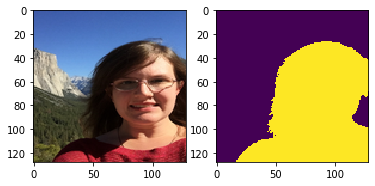

(128, 128, 3)
(128, 128, 1)


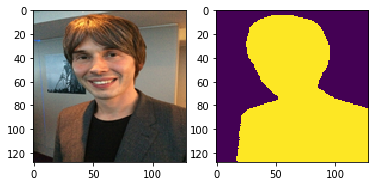

In [26]:
#Extract sample image to show per epoch
for image, mask in train.take(2):
    sample_image, sample_mask = image, mask
    print(sample_image.shape)
    print(sample_mask.shape)
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image[:,:,:])
    plt.subplot(1, 2, 2)
    plt.imshow(sample_mask[:,:,0])
    plt.show()

## Creating and tuning the SegNet

This notebook firstly constructs a SegNet based of the tutorial found here: https://www.tensorflow.org/tutorials/images/segmentation

A U-Net consts of an encoder and decoder.
We use a pre trained encoder using MobileNetV2.
The decoder is the upsample block defined in pix2pix tutorial

We define this model and then go onto tune parameters of it.

In [102]:
OUTPUT_CHANNELS = 1 # 2 possible labels (0-1)

In [103]:
#we use a a keras mobilenetv2 encoder
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3],include_top=False)
#Recall the encoder downsamples using a series of layers..
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32untitled:Untitled-6
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [104]:
import pydot
# Training we are looking at 3 classes for this so we use sparse_categorical_crossentropy - we would change this for binary
model =tf.keras.applications.MobileNetV2(input_shape=[128,128,3],include_top=False)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

##Lets look at the MobileNetMNodel 

#tf.keras.utils.plot_model(model, show_shapes=True)


Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_24[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [105]:
# Define the decoder
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

In [106]:
def unet_model_cv(layer_names,up_stack,output_channels=2,size=128):
    
    #we use a a keras mobilenetv2 encoder
    base_model = tf.keras.applications.MobileNetV2(input_shape=[size,size,3],include_top=False)
    #Recall the encoder downsamples using a series of layers..



    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = False    
    
    
    #last layer
    last = tf.keras.layers.Conv2DTranspose(
        output_channels,3,strides =2,
        padding='same',activation='softmax' #64x64 -> 128x128
    )
    
    inputs = tf.keras.layers.Input(shape=[size,size,3])
    x = inputs
    
    #downsample through each layer of the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])    
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)        

### Tune the encoder-decoder component

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_27 (Model)                [(None, 64, 64, 96), 1841984     input_32[0][0]                   
__________________________________________________________________________________________________
sequential_84 (Sequential)      (None, 8, 8, 512)    1476608     model_27[1][4]                   
__________________________________________________________________________________________________
concatenate_48 (Concatenate)    (None, 8, 8, 1088)   0           sequential_84[0][0]              
                                                                 model_27[1][3]            

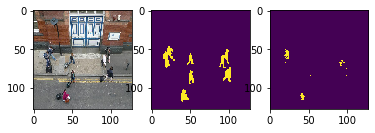


Sample Prediction after epoch 1

156/156 [==============================] - 20s 130ms/step - loss: 0.2659 - accuracy: 0.8769 - val_loss: 0.2439 - val_accuracy: 0.8927
Epoch 2/20
155/156 [============================>.] - ETA: 0s - loss: 0.2103 - accuracy: 0.8976

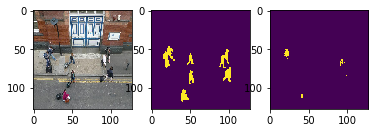


Sample Prediction after epoch 2

156/156 [==============================] - 10s 63ms/step - loss: 0.2102 - accuracy: 0.8976 - val_loss: 0.2633 - val_accuracy: 0.8880
Epoch 3/20
155/156 [============================>.] - ETA: 0s - loss: 0.1922 - accuracy: 0.9053 ETA: 1s -

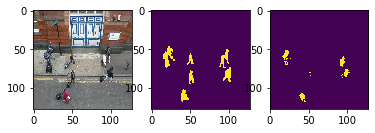


Sample Prediction after epoch 3

156/156 [==============================] - 9s 58ms/step - loss: 0.1921 - accuracy: 0.9053 - val_loss: 0.2463 - val_accuracy: 0.8940
Epoch 4/20
155/156 [============================>.] - ETA: 0s - loss: 0.1845 - accuracy: 0.9086 ETA: 0s -

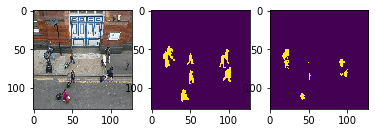


Sample Prediction after epoch 4

156/156 [==============================] - 9s 60ms/step - loss: 0.1845 - accuracy: 0.9086 - val_loss: 0.2440 - val_accuracy: 0.8934
Epoch 5/20
155/156 [============================>.] - ETA: 0s - loss: 0.1826 - accuracy: 0.9099

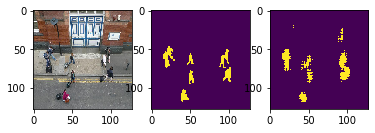


Sample Prediction after epoch 5

156/156 [==============================] - 9s 56ms/step - loss: 0.1829 - accuracy: 0.9097 - val_loss: 0.2392 - val_accuracy: 0.8926
Epoch 6/20
154/156 [============================>.] - ETA: 0s - loss: 0.1753 - accuracy: 0.9129 ETA: 1s - loss: 0.1747 - ac - ETA: 1s - loss: 0.1 - ETA: 0s - loss: 0.1753 - accuracy: 0.91

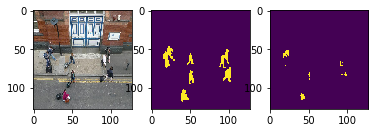


Sample Prediction after epoch 6

156/156 [==============================] - 9s 55ms/step - loss: 0.1753 - accuracy: 0.9129 - val_loss: 0.2606 - val_accuracy: 0.8874
Epoch 7/20
154/156 [============================>.] - ETA: 0s - loss: 0.1698 - accuracy: 0.9154

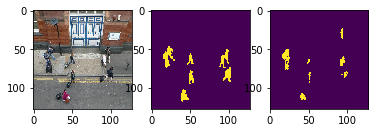


Sample Prediction after epoch 7

156/156 [==============================] - 8s 54ms/step - loss: 0.1701 - accuracy: 0.9152 - val_loss: 0.2287 - val_accuracy: 0.8981
Epoch 8/20
155/156 [============================>.] - ETA: 0s - loss: 0.1683 - accuracy: 0.9161

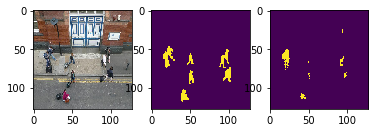


Sample Prediction after epoch 8

156/156 [==============================] - 9s 55ms/step - loss: 0.1682 - accuracy: 0.9162 - val_loss: 0.2466 - val_accuracy: 0.8932
Epoch 9/20
155/156 [============================>.] - ETA: 0s - loss: 0.1619 - accuracy: 0.9190

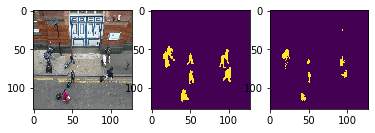


Sample Prediction after epoch 9

156/156 [==============================] - 9s 55ms/step - loss: 0.1617 - accuracy: 0.9191 - val_loss: 0.2618 - val_accuracy: 0.8948
Epoch 10/20
155/156 [============================>.] - ETA: 0s - loss: 0.1567 - accuracy: 0.9212

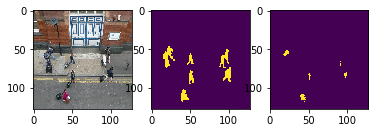


Sample Prediction after epoch 10

156/156 [==============================] - 9s 56ms/step - loss: 0.1568 - accuracy: 0.9211 - val_loss: 0.2489 - val_accuracy: 0.8949
Epoch 11/20
155/156 [============================>.] - ETA: 0s - loss: 0.1531 - accuracy: 0.9231 ETA: 2s - - ETA: 1s

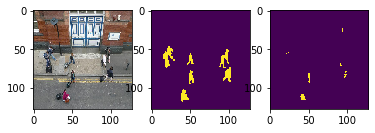


Sample Prediction after epoch 11

156/156 [==============================] - 8s 54ms/step - loss: 0.1531 - accuracy: 0.9231 - val_loss: 0.2497 - val_accuracy: 0.8933
Epoch 12/20
154/156 [============================>.] - ETA: 0s - loss: 0.1484 - accuracy: 0.9254

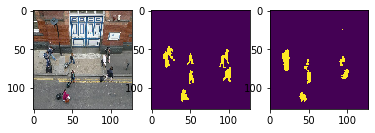


Sample Prediction after epoch 12

156/156 [==============================] - 9s 55ms/step - loss: 0.1486 - accuracy: 0.9252 - val_loss: 0.2478 - val_accuracy: 0.8947
Epoch 13/20
154/156 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9260

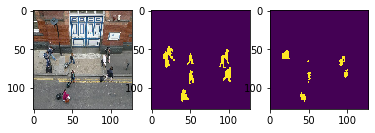


Sample Prediction after epoch 13

156/156 [==============================] - 8s 53ms/step - loss: 0.1464 - accuracy: 0.9261 - val_loss: 0.2472 - val_accuracy: 0.8993
Epoch 14/20
154/156 [============================>.] - ETA: 0s - loss: 0.1404 - accuracy: 0.9293

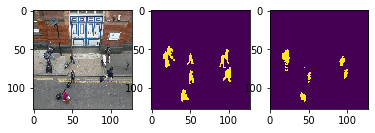


Sample Prediction after epoch 14

156/156 [==============================] - 8s 54ms/step - loss: 0.1407 - accuracy: 0.9291 - val_loss: 0.2466 - val_accuracy: 0.8971
Epoch 15/20
154/156 [============================>.] - ETA: 0s - loss: 0.1354 - accuracy: 0.9313

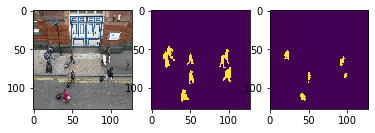


Sample Prediction after epoch 15

156/156 [==============================] - 9s 55ms/step - loss: 0.1353 - accuracy: 0.9313 - val_loss: 0.2857 - val_accuracy: 0.8929
Epoch 16/20
155/156 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9348

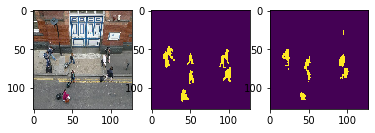


Sample Prediction after epoch 16

156/156 [==============================] - 8s 54ms/step - loss: 0.1285 - accuracy: 0.9348 - val_loss: 0.2469 - val_accuracy: 0.8970
Epoch 17/20
155/156 [============================>.] - ETA: 0s - loss: 0.1267 - accuracy: 0.9351

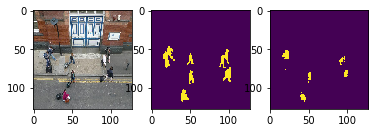


Sample Prediction after epoch 17

156/156 [==============================] - 9s 56ms/step - loss: 0.1266 - accuracy: 0.9352 - val_loss: 0.2710 - val_accuracy: 0.8968
Validation Loss is: [0.24390721122423809, 0.26326771477858224, 0.246320042014122, 0.24401946266492208, 0.23919308086236318, 0.2605561564366023, 0.22865201930205029, 0.24657202363014222, 0.2617894430955251, 0.24893834094206493, 0.24970166385173798, 0.2477537343899409, 0.2472335934638977, 0.2466010441382726, 0.28568738798300425, 0.24687007665634156, 0.2710414359966914]
range(0, 17)


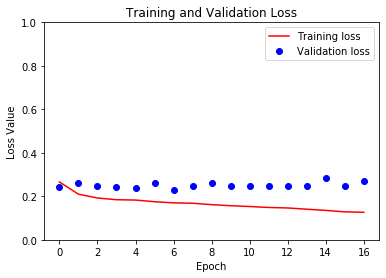

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_29 (Model)                [(None, 64, 64, 96), 715904      input_34[0][0]                   
__________________________________________________________________________________________________
sequential_88 (Sequential)      (None, 8, 8, 512)    739328      model_29[1][4]                   
__________________________________________________________________________________________________
concatenate_52 (Concatenate)    (None, 8, 8, 1088)   0           sequential_88[0][0]              
                                                                 model_29[1][3]            

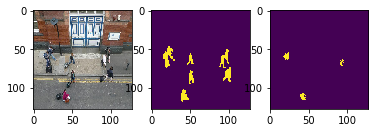


Sample Prediction after epoch 1

156/156 [==============================] - 17s 110ms/step - loss: 0.2554 - accuracy: 0.8792 - val_loss: 0.2551 - val_accuracy: 0.8909
Epoch 2/20
154/156 [============================>.] - ETA: 0s - loss: 0.2114 - accuracy: 0.8967

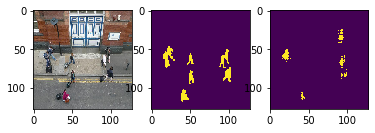


Sample Prediction after epoch 2

156/156 [==============================] - 8s 53ms/step - loss: 0.2115 - accuracy: 0.8966 - val_loss: 0.2448 - val_accuracy: 0.8913
Epoch 3/20
154/156 [============================>.] - ETA: 0s - loss: 0.2029 - accuracy: 0.9002

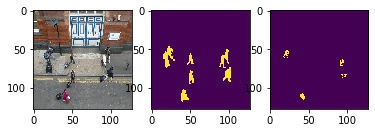


Sample Prediction after epoch 3

156/156 [==============================] - 8s 53ms/step - loss: 0.2029 - accuracy: 0.9003 - val_loss: 0.2968 - val_accuracy: 0.8824
Epoch 4/20
154/156 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9046

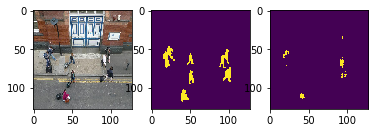


Sample Prediction after epoch 4

156/156 [==============================] - 8s 53ms/step - loss: 0.1937 - accuracy: 0.9047 - val_loss: 0.2426 - val_accuracy: 0.8939
Epoch 5/20
154/156 [============================>.] - ETA: 0s - loss: 0.1881 - accuracy: 0.9072

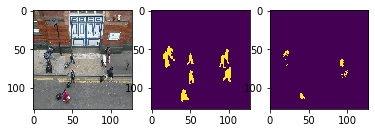


Sample Prediction after epoch 5

156/156 [==============================] - 8s 54ms/step - loss: 0.1878 - accuracy: 0.9073 - val_loss: 0.2641 - val_accuracy: 0.8899
Epoch 6/20
155/156 [============================>.] - ETA: 0s - loss: 0.1845 - accuracy: 0.9089

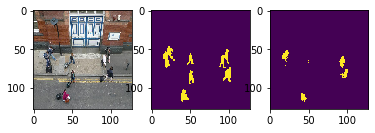


Sample Prediction after epoch 6

156/156 [==============================] - 8s 54ms/step - loss: 0.1848 - accuracy: 0.9087 - val_loss: 0.2464 - val_accuracy: 0.8942
Epoch 7/20
155/156 [============================>.] - ETA: 0s - loss: 0.1808 - accuracy: 0.9108

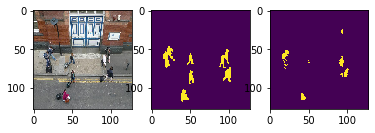


Sample Prediction after epoch 7

156/156 [==============================] - 8s 52ms/step - loss: 0.1808 - accuracy: 0.9108 - val_loss: 0.2472 - val_accuracy: 0.8910
Epoch 8/20
154/156 [============================>.] - ETA: 0s - loss: 0.1738 - accuracy: 0.9138

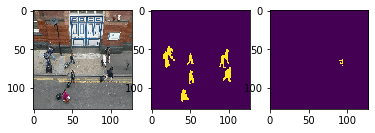


Sample Prediction after epoch 8

156/156 [==============================] - 8s 54ms/step - loss: 0.1740 - accuracy: 0.9137 - val_loss: 0.3170 - val_accuracy: 0.8740
Epoch 9/20
155/156 [============================>.] - ETA: 0s - loss: 0.1721 - accuracy: 0.9143

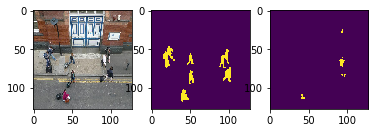


Sample Prediction after epoch 9

156/156 [==============================] - 8s 53ms/step - loss: 0.1720 - accuracy: 0.9143 - val_loss: 0.2665 - val_accuracy: 0.8922
Epoch 10/20
154/156 [============================>.] - ETA: 0s - loss: 0.1702 - accuracy: 0.9155 ETA: 0s - loss: 0.169

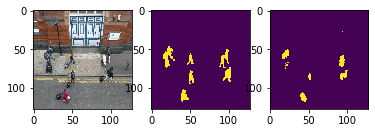


Sample Prediction after epoch 10

156/156 [==============================] - 8s 53ms/step - loss: 0.1699 - accuracy: 0.9157 - val_loss: 0.2695 - val_accuracy: 0.8922
Epoch 11/20
155/156 [============================>.] - ETA: 0s - loss: 0.1675 - accuracy: 0.9165

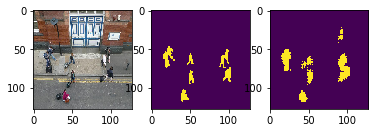


Sample Prediction after epoch 11

156/156 [==============================] - 8s 52ms/step - loss: 0.1676 - accuracy: 0.9165 - val_loss: 0.2687 - val_accuracy: 0.8852
Epoch 12/20
155/156 [============================>.] - ETA: 0s - loss: 0.1630 - accuracy: 0.9184

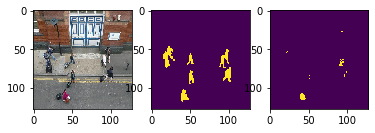


Sample Prediction after epoch 12

156/156 [==============================] - 8s 53ms/step - loss: 0.1631 - accuracy: 0.9183 - val_loss: 0.2543 - val_accuracy: 0.8961
Epoch 13/20
155/156 [============================>.] - ETA: 0s - loss: 0.1555 - accuracy: 0.9221

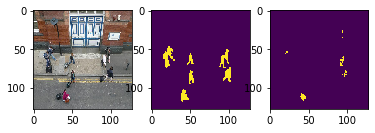


Sample Prediction after epoch 13

156/156 [==============================] - 8s 53ms/step - loss: 0.1555 - accuracy: 0.9221 - val_loss: 0.2563 - val_accuracy: 0.8887
Epoch 14/20
155/156 [============================>.] - ETA: 0s - loss: 0.1545 - accuracy: 0.9226

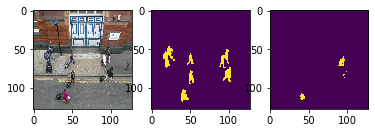


Sample Prediction after epoch 14

156/156 [==============================] - 8s 54ms/step - loss: 0.1544 - accuracy: 0.9226 - val_loss: 0.2636 - val_accuracy: 0.8943
Validation Loss is: [0.2550603618224462, 0.244820366303126, 0.29681793649991356, 0.24258354206879934, 0.2641467362642288, 0.2464287708202998, 0.24721112251281738, 0.31697405576705934, 0.26652784645557404, 0.26950676341851554, 0.268736340602239, 0.25425410668055215, 0.25632386803627016, 0.2636107603708903]
range(0, 14)


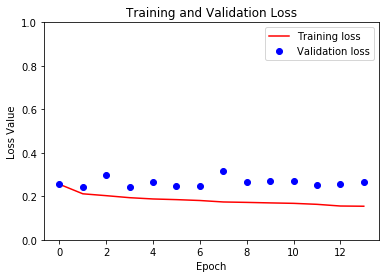

Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_31 (Model)                [(None, 64, 64, 96), 80704       input_36[0][0]                   
__________________________________________________________________________________________________
sequential_92 (Sequential)      (None, 16, 16, 256)  148480      model_31[1][3]                   
__________________________________________________________________________________________________
concatenate_56 (Concatenate)    (None, 16, 16, 448)  0           sequential_92[0][0]              
                                                                 model_31[1][2]            

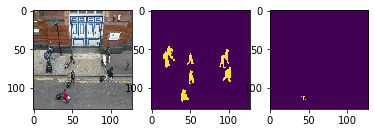


Sample Prediction after epoch 1

156/156 [==============================] - 15s 96ms/step - loss: 0.3069 - accuracy: 0.8514 - val_loss: 0.4924 - val_accuracy: 0.8347
Epoch 2/20
155/156 [============================>.] - ETA: 0s - loss: 0.2680 - accuracy: 0.8664

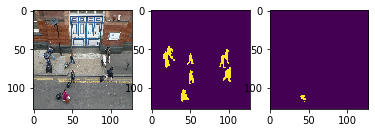


Sample Prediction after epoch 2

156/156 [==============================] - 7s 45ms/step - loss: 0.2683 - accuracy: 0.8664 - val_loss: 0.3308 - val_accuracy: 0.8520
Epoch 3/20
154/156 [============================>.] - ETA: 0s - loss: 0.2593 - accuracy: 0.8706

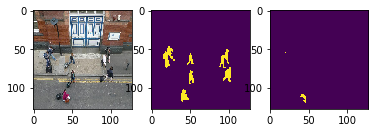


Sample Prediction after epoch 3

156/156 [==============================] - 7s 44ms/step - loss: 0.2591 - accuracy: 0.8707 - val_loss: 0.3719 - val_accuracy: 0.8507
Epoch 4/20
155/156 [============================>.] - ETA: 0s - loss: 0.2552 - accuracy: 0.8735

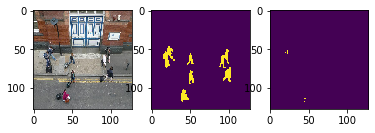


Sample Prediction after epoch 4

156/156 [==============================] - 7s 46ms/step - loss: 0.2550 - accuracy: 0.8736 - val_loss: 0.3947 - val_accuracy: 0.8464
Epoch 5/20
154/156 [============================>.] - ETA: 0s - loss: 0.2483 - accuracy: 0.8764

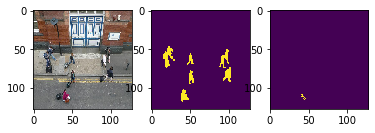


Sample Prediction after epoch 5

156/156 [==============================] - 7s 45ms/step - loss: 0.2490 - accuracy: 0.8759 - val_loss: 0.3858 - val_accuracy: 0.8482
Epoch 6/20
155/156 [============================>.] - ETA: 0s - loss: 0.2479 - accuracy: 0.8767

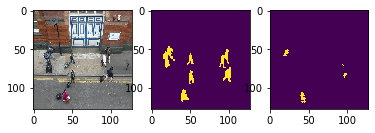


Sample Prediction after epoch 6

156/156 [==============================] - 7s 44ms/step - loss: 0.2482 - accuracy: 0.8765 - val_loss: 0.3840 - val_accuracy: 0.8502
Epoch 7/20
155/156 [============================>.] - ETA: 0s - loss: 0.2444 - accuracy: 0.8785

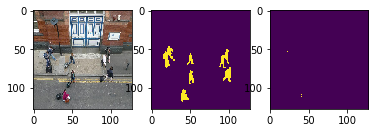


Sample Prediction after epoch 7

156/156 [==============================] - 7s 44ms/step - loss: 0.2445 - accuracy: 0.8785 - val_loss: 0.3497 - val_accuracy: 0.8504
Epoch 8/20
155/156 [============================>.] - ETA: 0s - loss: 0.2410 - accuracy: 0.8798

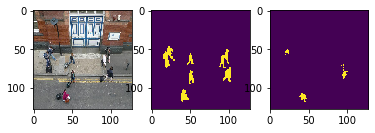


Sample Prediction after epoch 8

156/156 [==============================] - 7s 43ms/step - loss: 0.2407 - accuracy: 0.8799 - val_loss: 0.3206 - val_accuracy: 0.8612
Epoch 9/20
154/156 [============================>.] - ETA: 0s - loss: 0.2390 - accuracy: 0.8811

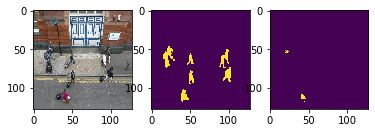


Sample Prediction after epoch 9

156/156 [==============================] - 7s 44ms/step - loss: 0.2389 - accuracy: 0.8811 - val_loss: 0.3798 - val_accuracy: 0.8500
Epoch 10/20
155/156 [============================>.] - ETA: 0s - loss: 0.2342 - accuracy: 0.8834

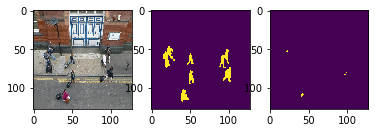


Sample Prediction after epoch 10

156/156 [==============================] - 7s 44ms/step - loss: 0.2341 - accuracy: 0.8834 - val_loss: 0.4145 - val_accuracy: 0.8483
Epoch 11/20
154/156 [============================>.] - ETA: 0s - loss: 0.2349 - accuracy: 0.8836

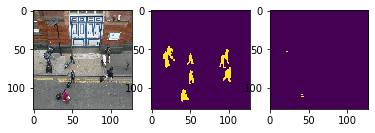


Sample Prediction after epoch 11

156/156 [==============================] - 7s 45ms/step - loss: 0.2351 - accuracy: 0.8835 - val_loss: 0.4246 - val_accuracy: 0.8408
Epoch 12/20
155/156 [============================>.] - ETA: 0s - loss: 0.2347 - accuracy: 0.8832

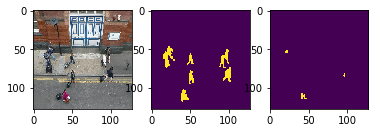


Sample Prediction after epoch 12

156/156 [==============================] - 7s 44ms/step - loss: 0.2348 - accuracy: 0.8832 - val_loss: 0.3890 - val_accuracy: 0.8523
Epoch 13/20
155/156 [============================>.] - ETA: 0s - loss: 0.2319 - accuracy: 0.8847

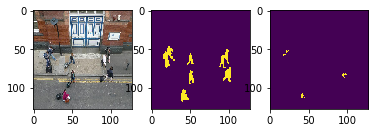


Sample Prediction after epoch 13

156/156 [==============================] - 7s 43ms/step - loss: 0.2319 - accuracy: 0.8846 - val_loss: 0.3464 - val_accuracy: 0.8582
Epoch 14/20
154/156 [============================>.] - ETA: 0s - loss: 0.2297 - accuracy: 0.8855

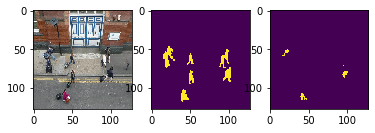


Sample Prediction after epoch 14

156/156 [==============================] - 7s 45ms/step - loss: 0.2297 - accuracy: 0.8855 - val_loss: 0.4124 - val_accuracy: 0.8534
Epoch 15/20
155/156 [============================>.] - ETA: 0s - loss: 0.2264 - accuracy: 0.8879

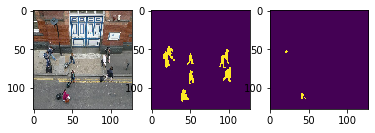


Sample Prediction after epoch 15

156/156 [==============================] - 7s 45ms/step - loss: 0.2263 - accuracy: 0.8880 - val_loss: 0.3721 - val_accuracy: 0.8528
Epoch 16/20
154/156 [============================>.] - ETA: 0s - loss: 0.2259 - accuracy: 0.8875

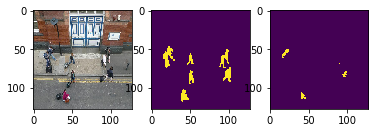


Sample Prediction after epoch 16

156/156 [==============================] - 7s 44ms/step - loss: 0.2264 - accuracy: 0.8871 - val_loss: 0.3375 - val_accuracy: 0.8618
Epoch 17/20
155/156 [============================>.] - ETA: 0s - loss: 0.2239 - accuracy: 0.8889

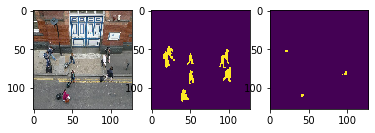


Sample Prediction after epoch 17

156/156 [==============================] - 7s 45ms/step - loss: 0.2249 - accuracy: 0.8884 - val_loss: 0.3515 - val_accuracy: 0.8568
Epoch 18/20
154/156 [============================>.] - ETA: 0s - loss: 0.2254 - accuracy: 0.8880

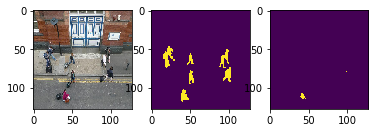


Sample Prediction after epoch 18

156/156 [==============================] - 7s 45ms/step - loss: 0.2254 - accuracy: 0.8880 - val_loss: 0.3923 - val_accuracy: 0.8553
Validation Loss is: [0.4923659563064575, 0.33078906734784447, 0.371869957447052, 0.39473725358645123, 0.3857863962650299, 0.38400496045748395, 0.3496977508068085, 0.32056918342908225, 0.37977670431137084, 0.4144723912080129, 0.4246426443258921, 0.3890409211317698, 0.346427055199941, 0.4123921632766724, 0.37211307883262634, 0.3375310609738032, 0.3514809141556422, 0.3922564129034678]
range(0, 18)


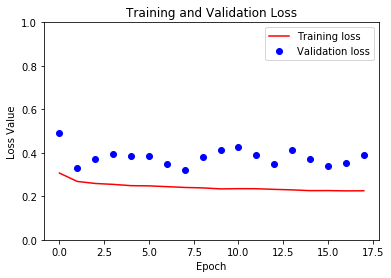

In [118]:
##Manually loop through each dict entry and train on it.
##Chaning the project block from 16 to 13
#Removing later features
#Removing earlier features 

param_grid = [
                {
    
                   'up_stack': [
                        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
                        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
                        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
                        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
                    ],
                    'layer_names': [
                        'block_1_expand_relu',   # 64x64
                        'block_3_expand_relu',   # 32x32
                        'block_6_expand_relu',   # 16x16
                        'block_13_expand_relu',  # 8x8
                        'block_16_project',      # 4x4
                    ]
                },    
                {
                    'up_stack' : [
                        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
                        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
                        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
                        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
                    ],
                    'layer_names'  : [
                        'block_1_expand_relu',   # 64x64
                        'block_3_expand_relu',   # 32x32
                        'block_6_expand_relu',   # 16x16
                        'block_13_expand_relu',  # 8x8
                        'block_13_project',  # 8x8
                    ]
                    
                },
    
                {
                    'up_stack' : [
                        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
                        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
                        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
                    ],

                    'layer_names' : [
                        'block_1_expand_relu',   # 64x64
                        'block_3_expand_relu',   # 32x32
                        'block_6_expand_relu',   # 16x16
                        'block_6_project',  # 8x8
                    ]
                },
    
]

#Now we train using a loop on each model.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
for elem in param_grid:
    #Shuffle dataset
    train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    test_dataset = test.batch(BATCH_SIZE)    
    
    #Create a model 
    model = unet_model_cv(elem['layer_names'],elem['up_stack'],OUTPUT_CHANNELS,128)
    #Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
     metrics=['accuracy'])
    
    model.summary()
    #Train Model
    EPOCHS = 20
    VAL_SUBSPLITS = 5
    VALIDATION_STEPS = 2500//BATCH_SIZE//VAL_SUBSPLITS

    model_history = model.fit(train_dataset, epochs=EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_dataset,
                              callbacks=[DisplayCallbackNoClear(),callback])
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    print("Validation Loss is:",val_loss)
    epochs = range(len(loss))
    print(epochs)

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'bo', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.legend() 
    plt.show()

### Final Tuned Model 

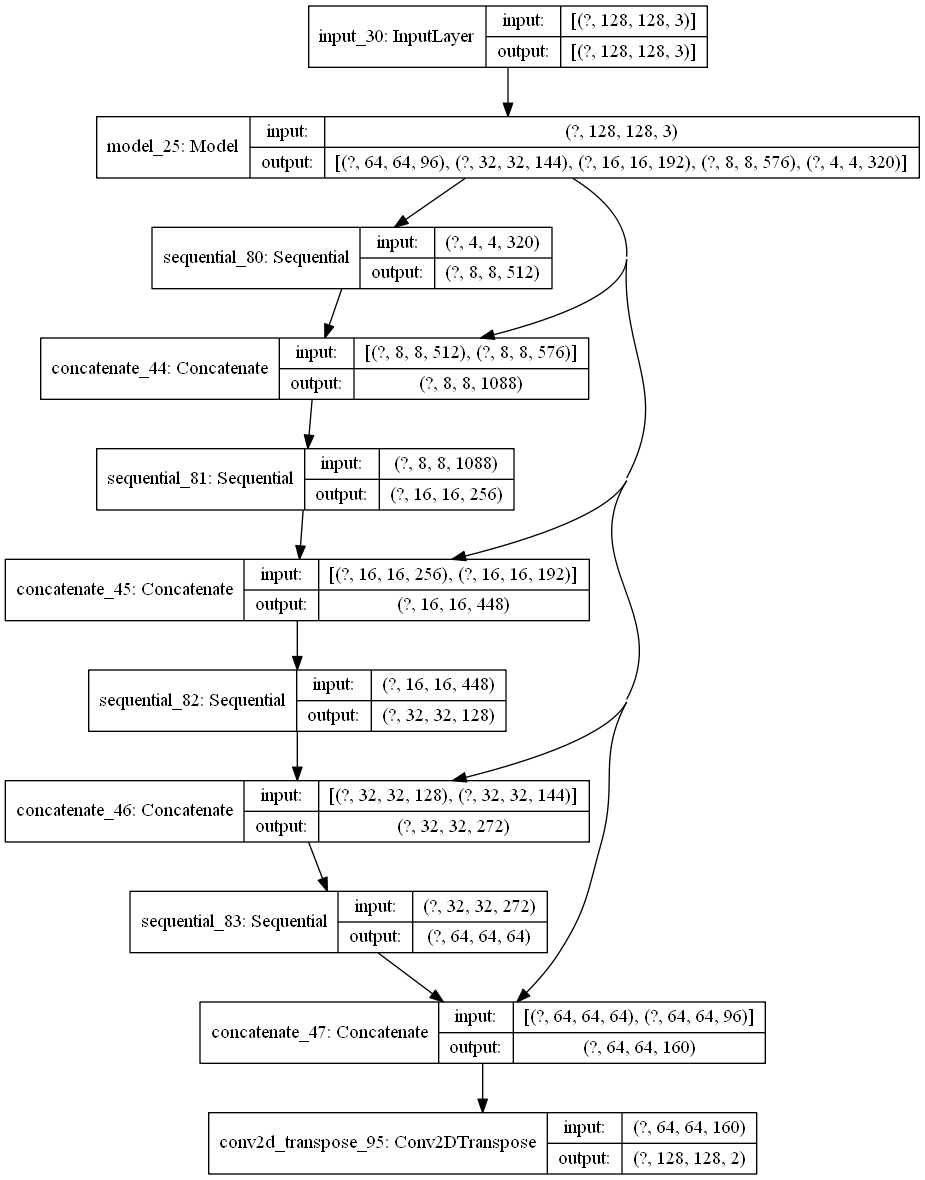

In [115]:

def unet_model(output_channels,size=128):
    base_model = tf.keras.applications.MobileNetV2(input_shape=[size,size,3],include_top=False)
    #Recall the encoder downsamples using a series of layers..
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]

    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = False  
    
    up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]
    
    #last layer
    last = tf.keras.layers.Conv2DTranspose(
        output_channels,3,strides =2,
        padding='same',activation='softmax' #64x64 -> 128x128
    )
    
    inputs = tf.keras.layers.Input(shape=[size,size,3])
    x = inputs
    
    #downsample through each layer of the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])    
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)    

model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

156
(128, 128, 3)
(128, 128, 1)


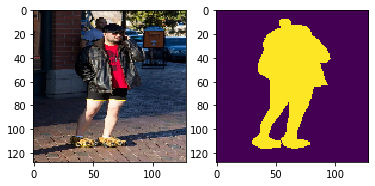

(128, 128, 3)
(128, 128, 1)


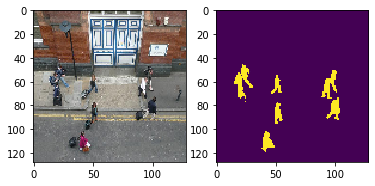

In [116]:
#we have only the training set for now.
TRAIN_LENGTH = 5000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
print(STEPS_PER_EPOCH)

train_dataset,test_dataset,train,test = generate_dataset('G:/tensorflow_data_set/tensorflow_records/train.tfrecords','G:/tensorflow_data_set/tensorflow_records/test.tfrecords',128)
for image, mask in train.take(2):
    sample_image, sample_mask = image, mask
    print(sample_image.shape)
    print(sample_mask.shape)
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image[:,:,:])
    plt.subplot(1, 2, 2)
    plt.imshow(sample_mask[:,:,0])
    plt.show()

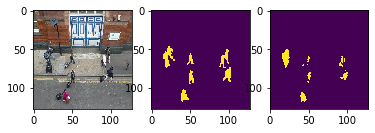


Sample Prediction after epoch 18

156/156 [==============================] - 9s 55ms/step - loss: 0.1263 - accuracy: 0.9354 - val_loss: 0.2654 - val_accuracy: 0.8938
Validation Loss is: [0.24379367530345916, 0.2605403502782186, 0.25603679815928143, 0.2565180599689484, 0.27368593315283457, 0.3014905919631322, 0.27228437463442484, 0.23792791465918223, 0.2500728964805603, 0.3111346513032913, 0.25009508430957794, 0.2729711274305979, 0.26537997225920357, 0.24396460950374604, 0.33377776145935056, 0.31355552275975546, 0.2728394071261088, 0.26540543138980865]
range(0, 18)


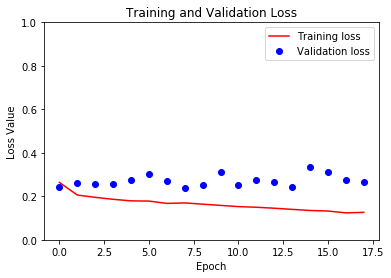

In [117]:
from tensorboard.plugins.hparams import api as hp

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 2500//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_dataset,
                              callbacks=[DisplayCallback(),callback])
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
print("Validation Loss is:",val_loss)
epochs = range(len(loss))
print(epochs)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend() 
plt.show()

### Tune Loss function and Optimizer
For this we can show the results in tensorboard

In [63]:
!taskkill /IM "tensorboard.exe" /F

ERROR: The process "tensorboard.exe" not found.


In [64]:
from tensorboard.plugins.hparams import api as hp

!rm -rf ./logs/ 

HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_LOSS = hp.HParam('losses', hp.Discrete(['sparse_categorical_crossentropy', 'binary_crossentropy','mean_squared_error']))
METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_OPTIMIZER, HP_LOSS],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [65]:
%load_ext tensorboard

%tensorboard --logdir logs/hparam_tuning --host localhost --port 9999


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 1972.

In [119]:
EPOCHS = 25
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 2500//BATCH_SIZE//VAL_SUBSPLITS
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

## Our optimized model which we now tune th eoptimizer and loss
def unet_model_cv(hparams,output_channels,size=128):

    
    base_model = tf.keras.applications.MobileNetV2(input_shape=[size,size,3],include_top=False)
    #Recall the encoder downsamples using a series of layers..
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]

    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = False  
    
    up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]
    
    #last layer
    last = tf.keras.layers.Conv2DTranspose(
        output_channels,3,strides =2,
        padding='same',activation='softmax' #64x64 -> 128x128
    )
    
    inputs = tf.keras.layers.Input(shape=[size,size,3])
    x = inputs
    
    #downsample through each layer of the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])    
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    model =  tf.keras.Model(inputs=inputs, outputs=x)      
    
    print("Compiling model!")
    model.compile(optimizer=hparams[HP_OPTIMIZER], loss=hparams[HP_LOSS],
                  metrics=['accuracy'])  
    print("Fitting Model")
    model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
              validation_steps=VALIDATION_STEPS,
                              validation_data=test_dataset,
                          callbacks=[callback])
    print("Training model")
    _,accuracy = model.evaluate(test_dataset) 
    return accuracy


def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = unet_model_cv(hparams,2)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

    
# Train on a combination of the Hparam log the results for display on tensorboard    
session_num = 0    
for opt in HP_OPTIMIZER.domain.values:
    for loss in HP_LOSS.domain.values:
        print(opt,loss)
        hparams = {
            HP_OPTIMIZER: opt,
            HP_LOSS: loss
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1

#tf.keras.utils.plot_model(model, show_shapes=True)

adam binary_crossentropy
--- Starting trial: run-0
{'optimizer': 'adam', 'losses': 'binary_crossentropy'}
Compiling model!
Fitting Model
Train for 156 steps, validate for 15 steps
Epoch 1/25
156/156 [==============================] - 12s 79ms/step - loss: 0.7078 - accuracy: 0.4917 - val_loss: 0.6948 - val_accuracy: 0.4912
Epoch 2/25
156/156 [==============================] - 9s 55ms/step - loss: 0.6944 - accuracy: 0.4917 - val_loss: 0.6935 - val_accuracy: 0.4912
Epoch 3/25
156/156 [==============================] - 8s 54ms/step - loss: 0.6937 - accuracy: 0.4917 - val_loss: 0.6933 - val_accuracy: 0.4912
Epoch 4/25
156/156 [==============================] - 9s 55ms/step - loss: 0.6934 - accuracy: 0.4917 - val_loss: 0.6933 - val_accuracy: 0.4912
Epoch 5/25
156/156 [==============================] - 9s 55ms/step - loss: 0.6934 - accuracy: 0.4917 - val_loss: 0.6932 - val_accuracy: 0.4912
Epoch 6/25
156/156 [==============================] - 9s 55ms/step - loss: 0.6933 - accuracy: 0.4917 - v

156/156 [==============================] - 8s 53ms/step - loss: 0.2050 - accuracy: 0.8997 - val_loss: 0.2519 - val_accuracy: 0.8896
Epoch 3/25
156/156 [==============================] - 8s 54ms/step - loss: 0.1978 - accuracy: 0.9031 - val_loss: 0.2406 - val_accuracy: 0.8919
Epoch 4/25
156/156 [==============================] - 8s 54ms/step - loss: 0.1878 - accuracy: 0.9077 - val_loss: 0.2449 - val_accuracy: 0.8918
Epoch 5/25
156/156 [==============================] - 8s 54ms/step - loss: 0.1804 - accuracy: 0.9108 - val_loss: 0.2539 - val_accuracy: 0.8911
Epoch 6/25
156/156 [==============================] - 9s 57ms/step - loss: 0.1743 - accuracy: 0.9136 - val_loss: 0.2307 - val_accuracy: 0.8978
Epoch 7/25
156/156 [==============================] - 8s 54ms/step - loss: 0.1715 - accuracy: 0.9149 - val_loss: 0.2605 - val_accuracy: 0.8897
Epoch 8/25
156/156 [==============================] - 8s 54ms/step - loss: 0.1671 - accuracy: 0.9169 - val_loss: 0.2651 - val_accuracy: 0.8908
Epoch 9/25

156/156 [==============================] - 8s 52ms/step - loss: 0.2532 - accuracy: 0.4984 - val_loss: 0.2520 - val_accuracy: 0.4945
Epoch 14/25
156/156 [==============================] - 8s 53ms/step - loss: 0.2530 - accuracy: 0.4985 - val_loss: 0.2518 - val_accuracy: 0.4954
Epoch 15/25
156/156 [==============================] - 8s 53ms/step - loss: 0.2528 - accuracy: 0.4986 - val_loss: 0.2517 - val_accuracy: 0.4950
Epoch 16/25
156/156 [==============================] - 8s 53ms/step - loss: 0.2527 - accuracy: 0.4988 - val_loss: 0.2516 - val_accuracy: 0.4951
Epoch 17/25
156/156 [==============================] - 8s 52ms/step - loss: 0.2525 - accuracy: 0.4988 - val_loss: 0.2515 - val_accuracy: 0.4954
Epoch 18/25
156/156 [==============================] - 8s 53ms/step - loss: 0.2524 - accuracy: 0.4989 - val_loss: 0.2514 - val_accuracy: 0.4958
Epoch 19/25
156/156 [==============================] - 8s 52ms/step - loss: 0.2522 - accuracy: 0.4991 - val_loss: 0.2513 - val_accuracy: 0.4961
Epoc

## Training the tuned model
From the tuned parameters we now train the model

In [109]:
#Compile the tuned model
OUTPUT_CHANNELS = 2
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [110]:
#Generates a mask for the image
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [111]:
import itertools 
#Called on each epoch. displays the Image, Ground truth and Predicted mask for each epoch
def show_predictions(dataset=None, num=1):
    if dataset:
        for image,mask in dataset.take(num):
            print(mask[0][:,:,0].shape)
            start = time.process_time()
            pred_mask = model.predict(image)
            print(time.process_time() - start)
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.subplot(1, 3, 2)
            plt.imshow(mask[0][:,:,0])
            plt.subplot(1, 3, 3)
            plt.imshow(create_mask(pred_mask)[:,:,0])
            plt.show()


    else:            
        plt.subplot(1, 3, 1)
        plt.imshow(sample_image)
        plt.subplot(1, 3, 2)
        plt.imshow(sample_mask[:,:,0])
        plt.subplot(1, 3, 3)
        plt.imshow(create_mask(model.predict(sample_image[tf.newaxis, ...]))[:,:,0])
        plt.show()


In [112]:
#Prepare gpu for training 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

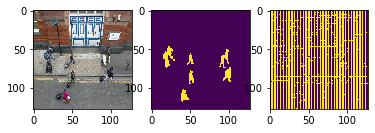

In [113]:
#show the untrained model mask
create_mask(model.predict(sample_image[tf.newaxis, ...]))
#untrained prediction
show_predictions()

In [108]:
#Callbacks are called at the end of each epoch, we use this for analysis

#Shows a test prediction at the end of each epoch - clears window output to keep notebook tidy
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
#Same as above, but does not clear output
class DisplayCallbackNoClear(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))        

In [85]:
#We use early stopping to save us time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

In [86]:
import os
#Save checkpoints as we train so we can resume later if needed
checkpoint_path = "G:/tensorflow_data_set/checkpoints"
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

G:/tensorflow_data_set/checkpoints


In [ ]:
#Training constants
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 2500//BATCH_SIZE//VAL_SUBSPLITS

#train the model
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(),callback])

In [ ]:
##save the weights

gen_loc = 'G:/tensorflow_data_set/model/'
person_lod = 'G:/tensorflow_data_set/person_model/'
model.save_weights(person_lod)


range(0, 25)


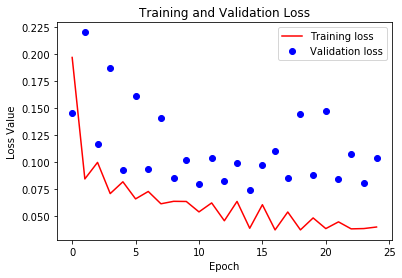

In [35]:
#Plot the training and validation loss for each epoch

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(loss))
print(epochs)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [ ]:
show_predictions(test_dataset,3)

In [ ]:
#Save the model in hdf5
#name = 'unet-coco.h5'
name = 'unet-portrait.h5'
model.save('G:/tensorflow_data_set/model/'+ name)

## Model Effect Prototype

This section is a playground used for investigating:
* inference time
* mask enhancement
* applying the effect to video

In [123]:
name = 'unet-coco.h5'
#name = 'unet-portrait.h5'
loaded_model = tf.keras.models.load_model('G:/tensorflow_data_set/model/'+name)


In [124]:
#test on a random image
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tensorflow.python.client import timeline
import cv2


In [125]:
#Generates soble points over a image
def generate_sobel(image):
    #src, depth,x ,y 
    sobelX = cv2.Sobel(image,cv2.CV_16S,1,0)
    sobelY = cv2.Sobel(image,cv2.CV_16S,0,1)
    sobel = np.hypot(sobelX,sobelY)
    sobel[sobel > 255] = 255
    return sobel

In [126]:
#Code used to enhnace a mask by applying a series of morphological processing effects
#This function was played around with before we ported this over to C++
def postProcess(frame,k_size=10):
    frame_subject = res[:,:,1]
    #binarize the mask
    frame_subject[frame_subject >= 0.1] = 1
    frame_subject[frame_subject < 0.1] = 0    
    #We erode the mask and dilate it with a 10x10 kernel
    kernel = np.ones((k_size,k_size),np.uint8)
    #Erode the image
    erosion = cv2.erode(frame_subject,kernel,iterations = 1)
    #Dilate the image
    dilation = cv2.dilate(erosion,kernel,iterations = 1)
    #Fill mask holes
    closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel) 
    
    #cast mask to uint8
    mask = closing.astype('uint8')
    
    
    ##This part applied grab cut to the image to find the largest contour. 
    #We found that this was not that useful and it was removed in the c++ implementation
    
    #Now we perform grab cut to extract the largest object from the mask
    edgeImage = generate_sobel(mask) 
    
    #Get the contours and heirarchy of the mask
    contours, heirarchy = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #break if we have no hierarchy
    if(heirarchy is None):
        return mask
    if(heirarchy[0] is None):
        return mask
    
    #Find largest contour shape , this is the person we keep in subject
    level1 = []
    
    for i,tupl in enumerate(heirarchy[0]):
        #tuple = Next, Prev, First Child, Parent
        #ignore tuples without parents
        if tupl[3] == -1:
            tupl = np.insert(tupl,0,[i])
            level1.append(tupl)
    
    #iterate over the top level contours, get the largest contour
    sig = []
    tooSmall = edgeImage.size * 5/100 #minimum contour area 
    for tupl in level1:
        contour = contours[tupl[0]]
        area = cv2.contourArea(contour) #contour computed area
        if area > tooSmall:

            sig.append([contour,area])

            #cv2.drawContours(image,[contour],0,(0,255,0),2,cv2.LINE_AA,maxLevel=1)    
    
    sig.sort(key=lambda x: x[1])   

    epsilon = 0.10 * cv2.arcLength(contour, True)
    # or epsilon = 3, so slighter contour corrections
    approx = cv2.approxPolyDP(contour, epsilon, True)
    contour = approx 
    
    #get point set
    pointset = [x[0] for x in sig]
    
    mask_new = np.zeros(mask.shape, np.uint8)

    #create the mask 
    cv2.fillPoly(mask_new, pointset, 255)
    
    return mask_new


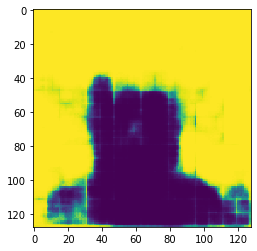

0.28125


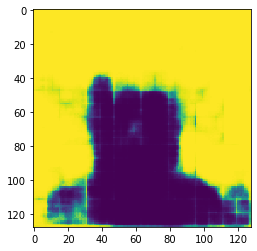

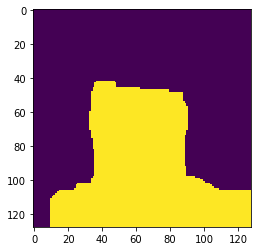

In [49]:
#Fast way to load images

with tf.device("/cpu:0"):
    
    start = time.process_time()
    doggo1 =  Image.open('me.jpg')
    doggo1 = doggo1.resize((128, 128), Image.ANTIALIAS)
    #convert the image to a np array
    doggo1 = np.array(doggo1)

    doggo1 = tf.image.convert_image_dtype(doggo1, dtype=tf.float32, saturate=False)
    
    res = loaded_model.predict(np.array([np.array(doggo1)]))[0]
    plt.imshow(res[:,:,0])
    plt.show()
    mask_result = postProcess(res)
    
    print(time.process_time() - start)
    plt.imshow(res[:,:,0])   
    plt.show()
    plt.imshow(mask_result)   
    plt.show()    

1.828125


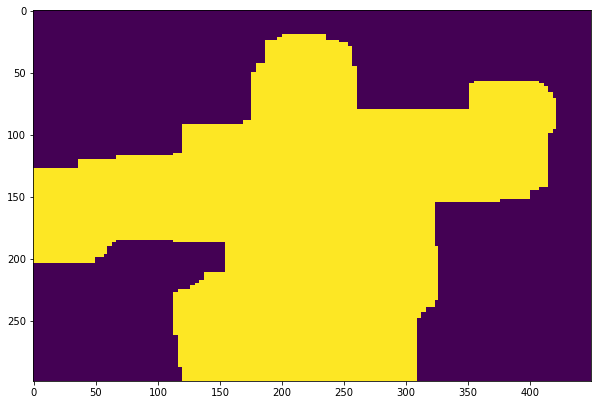

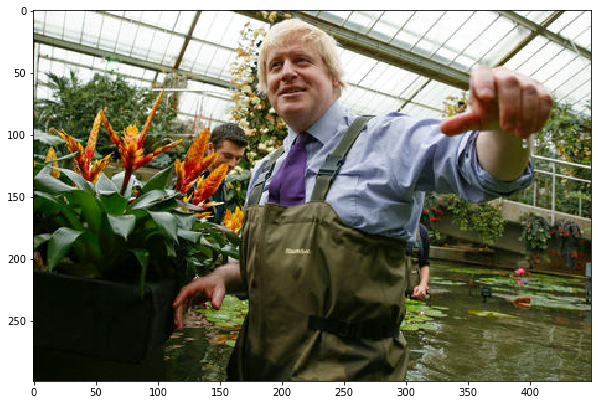

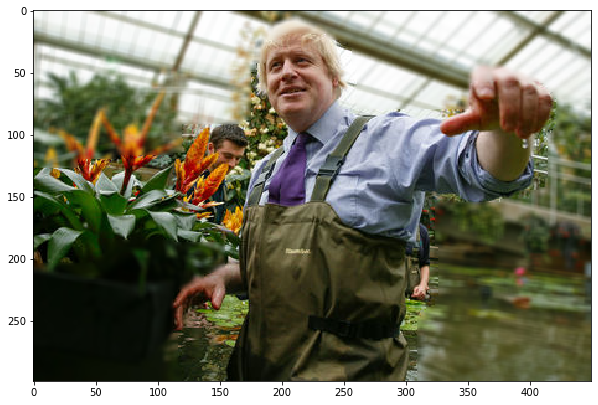

In [127]:
#Fast way to load images
import time
import numpy as np
import cv2
with tf.device("/cpu:0"):
    
    start = time.process_time()
    doggo_original =  Image.open('bojo.jpg')
    doggo1 = doggo_original.resize((128, 128), Image.ANTIALIAS)
    #convert the image to a np array
    doggo1 = np.array(doggo1)

    doggo1 = tf.image.convert_image_dtype(doggo1, dtype=tf.float32, saturate=False)

    
    res = loaded_model.predict(np.array([np.array(doggo1)]))[0]
    
    mask_result = postProcess(res)
    
    #apply the mask to the image
    new_image = np.array(doggo_original)
    
    #resize the mask 
    
    #blurMask = Image.fromarray(mask_result) 
    
    
    #blurMask =  blurMask.resize((672,896), Image.ANTIALIAS)
    blurMask = cv2.resize(mask_result, dsize=(450,299), interpolation=cv2.INTER_NEAREST )
    blurMask_RGB = np.array([blurMask,blurMask,blurMask])
    
    
    #imageAllBlurred = cv2.medianBlur(new_image,25)
    imageAllBlurred = cv2.blur(new_image,(5,5))
    imageBlurredInMask = imageAllBlurred
    for i in range(3):
        imageBlurredInMask[:,:,i] = np.where(blurMask==0,imageAllBlurred[:,:,i],new_image[:,:,i])

    
    print(time.process_time() - start)
    #fig = plt.figure(figsize=(10,10))
    #plt.imshow(res[:,:,0])   
    #plt.show()  
    fig = plt.figure(figsize=(10,10))
    plt.imshow(blurMask)   
    plt.show()  
    fig = plt.figure(figsize=(10,10))
    plt.imshow(new_image)   
    plt.show()      
    fig = plt.figure(figsize=(10,10))
    plt.imshow(imageBlurredInMask)   
    plt.show()  

## Testing Videos
Some test code to generate blurring masks over videos

In [ ]:
import cv2
#Load a video
cap = cv2.VideoCapture('sample_videos/btea.mp4')

In [ ]:
#Writing a video from a capture
writer = None
framerate = int(cap.get(cv2.CAP_PROP_FPS))

W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

writer = cv2.VideoWriter("out4.mp4",cv2.VideoWriter_fourcc('M','P','G','4'),framerate,(W,H))

start = time.time()

skipper = 15
frame_count = 0 
print(cap.get(cv2.CAP_PROP_FRAME_COUNT))
with tf.device("/cpu:0"):
    while(cap.isOpened()):
        ret, frame = cap.read()
        if(ret==True):
            im_copy=frame.copy()
            #resize the frame
            im_copy =cv2.resize(im_copy, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
            #convert the image to a np array

            im_copy = tf.image.convert_image_dtype(im_copy, dtype=tf.float32, saturate=False)

            
            ##check if we should generate a new mask
            if (frame_count % skipper == 0  or frame_count == 0 ):
                print("Updating mask")
                #generate the mask
                res = loaded_model.predict(np.array([np.array(im_copy)]))[0]
                #post process
                mask =  postProcess(res)
                #Grab cut to get largest segment
                #resize the mask
                blurMask = cv2.resize(mask, dsize=(W, H), interpolation=cv2.INTER_CUBIC)
                
            imageAllBlurred =cv2.GaussianBlur(frame,(25,25),cv2.BORDER_DEFAULT) #cv2.medianBlur(frame,25)
            imageBlurredInMask = imageAllBlurred
            for i in range(3):
                imageBlurredInMask[:,:,i] = np.where(blurMask==0,imageAllBlurred[:,:,i],frame[:,:,i])

            writer.write(imageBlurredInMask)
            # Display the resulting frame    
            frame_count = frame_count+1
        else:
            break
    cap.release()
    writer.release()
    end = time.time()
    print("[INFO] YOLO took {:.6f} seconds".format(end - start))

